# In This Notebook
* Check how convolutions work

# References
* https://setosa.io/ev/image-kernels/
* https://www.kaggle.com/code/jsrshivam/convolve-from-scratch
* https://www.youtube.com/watch?v=KuXjwB4LzSA
* https://github.com/detkov/Convolution-From-Scratch/tree/main

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torchvision

# Convolution with PyTorch

First, we need to understand what a convolution is. Convolution is a mathematical operation performed between two functions. In our case, the convolution is done between an image and a filter. The filter is a matrix that is applied to the image.

I will start by opening an image of one of my cats, Safira.

In [3]:
def read_image(image_path: str, grayscale: bool = False) -> PIL.Image.Image:
    image = PIL.Image.open(image_path)
    if grayscale:
        image = image.convert("L")
    return image


def plot_image(image: PIL.Image.Image, title: str = "") -> None:
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [4]:
filepath = "../assets/safira.jpg"
image = read_image(filepath)
print(image.size)

(871, 653)


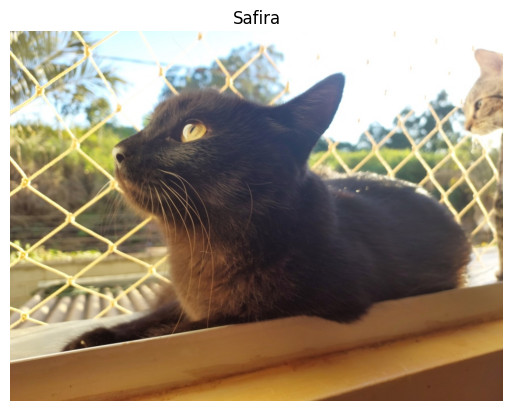

In [5]:
plot_image(image, title="Safira")

Here, I will open the image in grayscale and plot it.

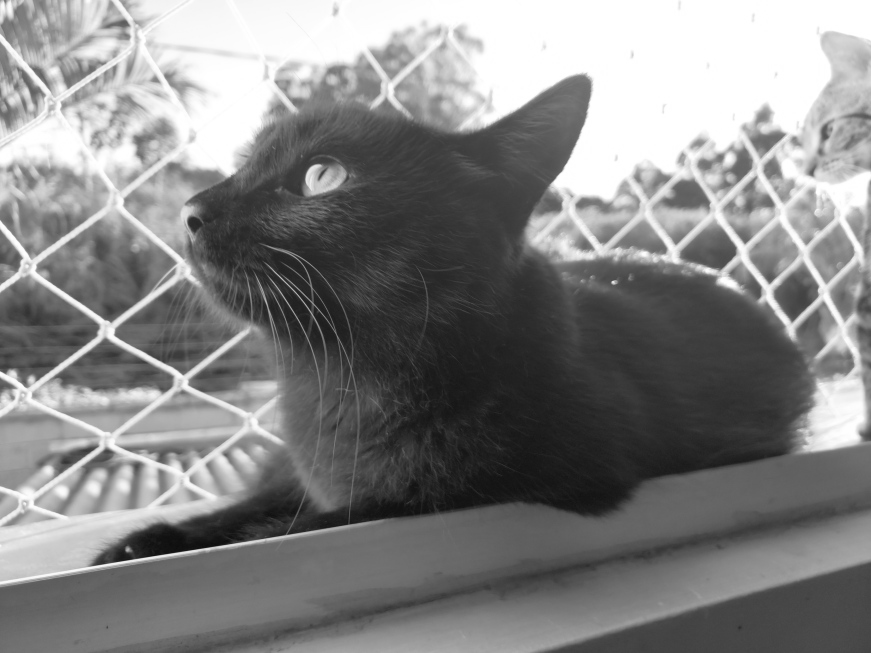

In [9]:
image = read_image(filepath, grayscale=True)
image

Here I instantiate a convolutional layer with a 3x3 filter and apply the convolution to the image.

In [10]:
conv = torch.nn.Conv2d(in_channels=1, out_channels=9, kernel_size=3)

image_tensor = torchvision.transforms.functional.to_tensor(image)
image = image_tensor.unsqueeze(0) / 255.0
output = conv(image)

In [11]:
output.shape

torch.Size([1, 9, 651, 869])

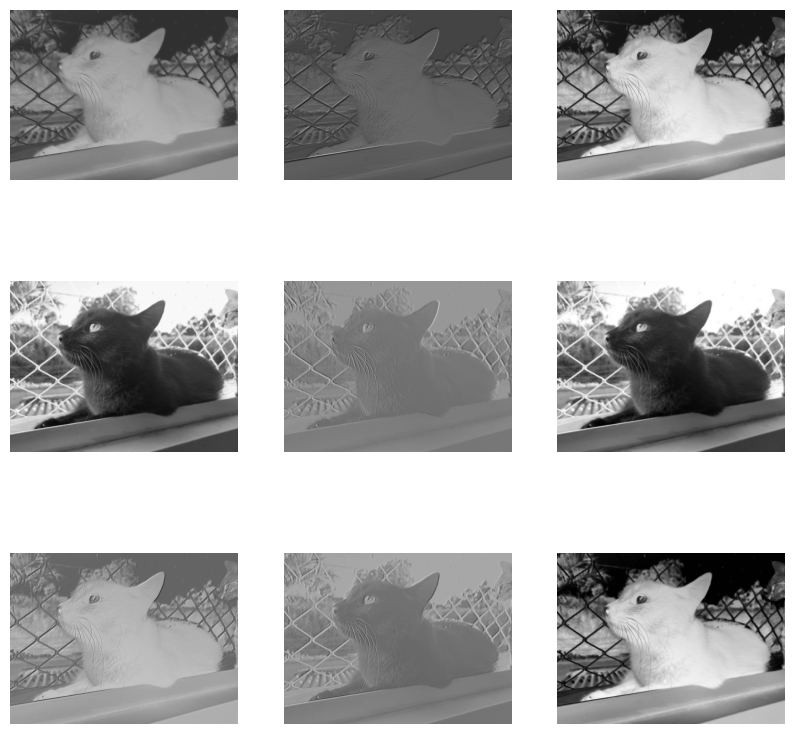

In [ ]:
fig = plt.figure(figsize=(10, 10))

for n, image in enumerate(output[0]):
    image_min, image_max = image.min(), image.max()
    image = (image - image_min) / (image_max - image_min)
    image *= 255.0

    fig.add_subplot(3, 3, n + 1)
    plt.imshow(image.detach().numpy(), cmap="gray")
    plt.axis("off")

# Convolution from scratch with numpy

In [13]:
import numpy as np
from typing import List, Tuple, Union


def add_padding(matrix: np.ndarray, padding: Tuple[int, int]) -> np.ndarray:
    """Adds padding to the matrix.

    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix

    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
    """
    n, m = matrix.shape
    r, c = padding

    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix

    return padded_matrix


def _check_params(matrix, kernel, stride, dilation, padding):
    params_are_correct = (
        isinstance(stride[0], int)
        and isinstance(stride[1], int)
        and isinstance(dilation[0], int)
        and isinstance(dilation[1], int)
        and isinstance(padding[0], int)
        and isinstance(padding[1], int)
        and stride[0] >= 1
        and stride[1] >= 1
        and dilation[0] >= 1
        and dilation[1] >= 1
        and padding[0] >= 0
        and padding[1] >= 0
    )
    assert params_are_correct, "Parameters should be integers equal or greater than default values."
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    n, m = matrix.shape
    matrix = matrix if list(padding) == [0, 0] else add_padding(matrix, padding)
    n_p, m_p = matrix.shape

    if not isinstance(kernel, np.ndarray):
        kernel = np.array(kernel)
    k = kernel.shape

    kernel_is_correct = k[0] % 2 == 1 and k[1] % 2 == 1
    assert kernel_is_correct, "Kernel shape should be odd."
    matrix_to_kernel_is_correct = n_p >= k[0] and m_p >= k[1]
    assert matrix_to_kernel_is_correct, "Kernel can't be bigger than matrix in terms of shape."

    h_out = np.floor((n + 2 * padding[0] - k[0] - (k[0] - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - k[1] - (k[1] - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    out_dimensions_are_correct = h_out > 0 and w_out > 0
    assert out_dimensions_are_correct, (
        "Can't apply input parameters, one of resulting output dimension is non-positive."
    )

    return matrix, kernel, k, h_out, w_out


def conv2d(
    matrix: Union[List[List[float]], np.ndarray],
    kernel: Union[List[List[float]], np.ndarray],
    stride: Tuple[int, int] = (1, 1),
    dilation: Tuple[int, int] = (1, 1),
    padding: Tuple[int, int] = (0, 0),
) -> np.ndarray:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.

    Args:
        matrix (Union[List[List[float]], np.ndarray]): 2D matrix to be convolved.
        kernel (Union[List[List[float]], np.ndarray]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).

    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    matrix, kernel, k, h_out, w_out = _check_params(matrix, kernel, stride, dilation, padding)
    matrix_out = np.zeros((h_out, w_out))

    b = k[0] // 2, k[1] // 2
    center_x_0 = b[0] * dilation[0]
    center_y_0 = b[1] * dilation[1]
    for i in range(h_out):
        center_x = center_x_0 + i * stride[0]
        indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
        for j in range(w_out):
            center_y = center_y_0 + j * stride[1]
            indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

            submatrix = matrix[indices_x, :][:, indices_y]

            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out


def apply_filter_to_image(image: np.ndarray, kernel: List[List[float]]) -> np.ndarray:
    """Applies filter to the given image.

    Args:
        image (np.ndarray): 3D matrix to be convolved. Shape must be in HWC format.
        kernel (List[List[float]]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).

    Returns:
        np.ndarray: image after applying kernel.
    """
    kernel = np.asarray(kernel)
    b = kernel.shape
    return np.dstack([conv2d(image[:, :, z], kernel, padding=(b[0] // 2, b[1] // 2)) for z in range(3)]).astype("uint8")

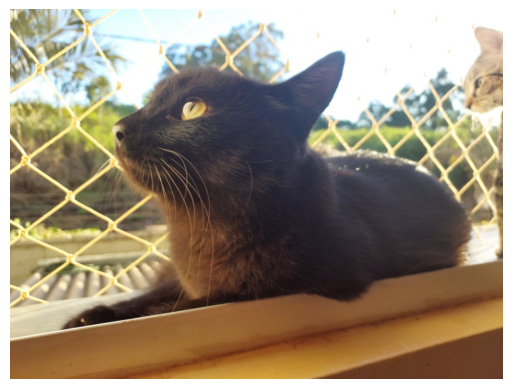

In [29]:
image = cv2.imread(filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.show()

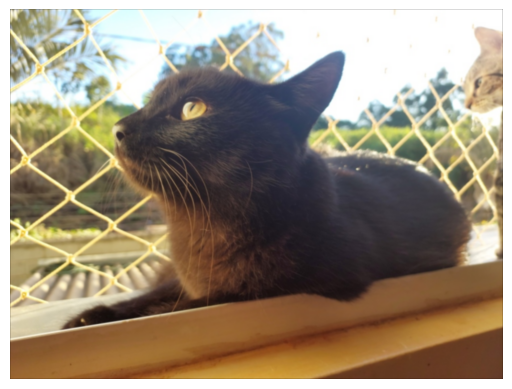

In [32]:
gaussian_blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

filtered_image = apply_filter_to_image(image, gaussian_blur)
plt.imshow(filtered_image)
plt.axis("off")
plt.show()

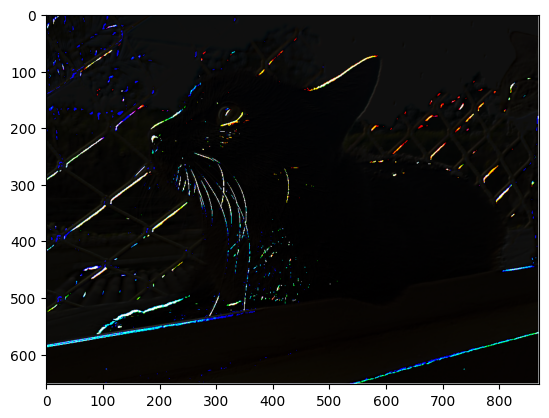

In [33]:
emboss = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
]) / 16

filtered_image = apply_filter_to_image(image, emboss)
plt.imshow(filtered_image)

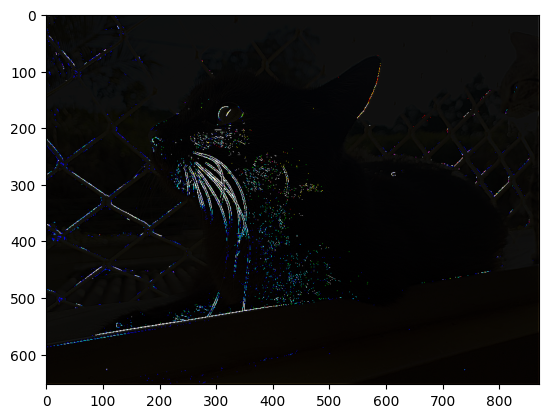

In [34]:
sharpen = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
]) / 16

filtered_image = apply_filter_to_image(image, sharpen)
plt.imshow(filtered_image)